### testの方も完全なwifiベースでデータセットを作成
testのreal timestampは公開notebookのものに変更

In [1]:
import pandas as pd
import numpy as np
import glob
import os
import gc
import json 
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
import dask
from dask.distributed import Client, wait, LocalCluster
from pathlib import Path
import warnings
warnings.simplefilter('ignore')

In [2]:
DATA_DIR = Path("../input/")

base_path = DATA_DIR/'indoor-location-navigation'

In [3]:
ssubm = pd.read_csv(DATA_DIR / 'fix_test_timestamp.csv')

ssubm_df = ssubm["site_path_timestamp"].apply(lambda x: pd.Series(x.split("_")))
ssubm_df.columns = ['site_id', 'path_id', 'timestamp']
ssubm_df['site_path_timestamp'] = ssubm['site_path_timestamp']
ssubm_df['real_timestamp'] = ssubm['real_timestamp']
ssubm_df['time_diff'] = ssubm_df['real_timestamp'].astype(int) - ssubm_df['timestamp'].astype(int)
used_buildings = sorted(ssubm_df['site_id'].value_counts().index.tolist())

floor_map = {"B2":-2.0, "B1":-1.0, "F1":0.0, "F2": 1.0, "F3":2.0, "F4":3.0, "F5":4.0, "F6":5.0, "F7":6.0,"F8":7.0, "F9":8.0,
             "1F":0.0, "2F":1.0, "3F":2.0, "4F":3.0, "5F":4.0, "6F":5.0, "7F":6.0, "8F": 7.0, "9F":8.0}
ssubm_df

,site_id,path_id,timestamp,site_path_timestamp,real_timestamp,time_diff
0,5a0546857ecc773753327266,046cfa46be49fc10834815c6,0000000000009,5a0546857ecc773753327266_046cfa46be49fc1083481...,1578474564146,1578474564137
1,5a0546857ecc773753327266,046cfa46be49fc10834815c6,0000000009017,5a0546857ecc773753327266_046cfa46be49fc1083481...,1578474573154,1578474564137
2,5a0546857ecc773753327266,046cfa46be49fc10834815c6,0000000015326,5a0546857ecc773753327266_046cfa46be49fc1083481...,1578474579463,1578474564137
3,5a0546857ecc773753327266,046cfa46be49fc10834815c6,0000000018763,5a0546857ecc773753327266_046cfa46be49fc1083481...,1578474582900,1578474564137
4,5a0546857ecc773753327266,046cfa46be49fc10834815c6,0000000022328,5a0546857ecc773753327266_046cfa46be49fc1083481...,1578474586465,1578474564137
...,...,...,...,...,...,...
10128,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,0000000082589,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,1573731143307,1573731060718
10129,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,0000000085758,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,1573731146476,1573731060718
10130,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,0000000090895,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,1573731151613,1573731060718
10131,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,0000000096899,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,1573731157617,1573731060718


In [4]:
def to_pickle(filename, obj):
    with open(filename, mode='wb') as f:
        pickle.dump(obj, f)

### site内で指定回以上登場するWiFiを抽出
100とかにしたかったが対象となるWiFiが少なすぎる。testのwaypointに紐づくWiFiの件数が少ない

In [5]:
# %%time

# # TODO 全体の登場回数ではなく、waypointの近くの登場回数で絞るべき
WIFI_USE_COUT = 10

# bssid = dict()

# for building in used_buildings:
#     #break
#     folders = sorted(glob.glob(os.path.join(base_path,'train/'+building+'/*')))
#     print(building)
#     wifi = list()
#     for folder in folders:
#         floor = floor_map[folder.split('/')[-1]]
#         files = glob.glob(os.path.join(folder, "*.txt"))
#         for file in files:
#             with open(file, encoding='utf-8') as f:
#                 txt = f.readlines()
#                 for e, line in enumerate(txt):
#                     tmp = line.strip().split()
#                     if tmp[1] == "TYPE_WIFI":
#                         wifi.append(tmp)
#     df = pd.DataFrame(wifi)
#     value_counts = df[3].value_counts()
#     top_bssid = value_counts[value_counts > WIFI_USE_COUT].index.tolist() # 50回以上登場するBSSIDのみを対象にする。
#     print(len(top_bssid))
#     bssid[building] = top_bssid
#     del df
#     del wifi
#     gc.collect()

# with open(f"bssid_{WIFI_USE_COUT}.json", "w") as f:
#     json.dump(bssid, f)

In [6]:
with open(f"bssid_{WIFI_USE_COUT}.json") as f:
    bssid = json.load(f)

In [7]:
def create_wifi_df(path_id):
    wifi = list()
    
    with open(os.path.join(str(base_path) + f'/test/{path_id}.txt'), encoding='utf-8') as f:
        txt = f.readlines()

    for line in txt:
        line = line.strip().split()
        if line[1] == "TYPE_WIFI":
            wifi.append(line)
            
    return pd.DataFrame(np.array(wifi), columns=['timestamp', 'data_type', 'ssid', 'bssid', 'rssi', 'frequency', 'last_seen_timestamp'])

 
wifi_base_df_counts_dfs = []
for path_id, path_df in tqdm(ssubm_df.groupby('path_id')):
    
    site_id = path_df.iloc[0]['site_id']
    bssids = bssid[site_id]
    
    wifi_base_df = create_wifi_df(path_id)
    wifi_base_df = wifi_base_df[wifi_base_df['bssid'].isin(bssids)]
    
    wifi_base_df_counts = wifi_base_df['bssid'].value_counts().reset_index()
    wifi_base_df_counts = wifi_base_df_counts.rename(columns={'index':'bssid', 'bssid':'count'})
    wifi_base_df_counts['site_id'] = site_id
    wifi_base_df_counts_dfs.append(wifi_base_df_counts)
    
#     break

100%|██████████| 626/626 [00:26<00:00, 23.26it/s]


In [8]:
wifi_base_df_counts_df = pd.concat(wifi_base_df_counts_dfs).reset_index(drop=True)
wifi_base_df_counts_df

,bssid,count,site_id
0,e607685c344d278a69f8f4d1443b5a9ddf4341ee,46,5da1389e4db8ce0c98bd0547
1,29c7d9e757292e7b2b3d00dc4dae7514531b20b4,46,5da1389e4db8ce0c98bd0547
2,2c0de2d831941a1ed5ed2873805e9f20bcc6776f,46,5da1389e4db8ce0c98bd0547
3,4a2924201ab4aaf5aedc8ca8f485bf1b343028cd,46,5da1389e4db8ce0c98bd0547
4,98d67fadac518296992afddd24e97a2855af9472,46,5da1389e4db8ce0c98bd0547
...,...,...,...
182475,46c934893439700099d03a6892ea934ecb2729d6,1,5a0546857ecc773753327266
182476,335fe70708ab8a19936380b24cc0d53be8b88b48,1,5a0546857ecc773753327266
182477,3c89886dd08bb4a24384cf8bc0c6423e4804e6e9,1,5a0546857ecc773753327266
182478,ae54f8552a572ddf81302b56c07f63c6321270be,1,5a0546857ecc773753327266


In [9]:
test_bssid = dict()
for building in tqdm(used_buildings):
    print(building)
    wifi_base_df_counts_df_unisite = wifi_base_df_counts_df[wifi_base_df_counts_df['site_id'] == building]
    wifi_base_df_counts_df_unisite_groupby = wifi_base_df_counts_df_unisite.groupby('bssid').sum().reset_index()
    top_bssid = wifi_base_df_counts_df_unisite_groupby[wifi_base_df_counts_df_unisite_groupby['count'] >= WIFI_USE_COUT]['bssid'].tolist()
    test_bssid[building] = top_bssid
    print(len(top_bssid))

 38%|███▊      | 9/24 [00:00<00:00, 85.86it/s]5a0546857ecc773753327266
2310
5c3c44b80379370013e0fd2b
993
5d27075f03f801723c2e360f
988
5d27096c03f801723c31e5e0
891
5d27097f03f801723c320d97
1032
5d27099f03f801723c32511d
535
5d2709a003f801723c3251bf
816
5d2709b303f801723c327472
1123
5d2709bb03f801723c32852c
1456
5d2709c303f801723c3299ee
4106
5d2709d403f801723c32bd39
1482
5d2709e003f801723c32d896
875
5da138274db8ce0c98bbd3d2
267
5da1382d4db8ce0c98bbe92e
1737
5da138314db8ce0c98bbf3a0
879
5da138364db8ce0c98bc00f1
472
5da1383b4db8ce0c98bc11ab
1045
5da138754db8ce0c98bca82f
1015
5da138764db8ce0c98bcaa46
100%|██████████| 24/24 [00:00<00:00, 86.87it/s]1157
5da1389e4db8ce0c98bd0547
372
5da138b74db8ce0c98bd4774
2258
5da958dd46f8266d0737457b
2770
5dbc1d84c1eb61796cf7c010
3452
5dc8cea7659e181adb076a3f
2260



In [10]:
from scipy import interpolate
def get_waypoint_by_linear_interpolation(
    observed_timestamp: np.ndarray, 
    observed_x:np.ndarray, 
    observed_y:np.ndarray, 
    target_timestamp:np.ndarray, 
    delta_time=500
    ):
    
    """
    observed: known Information
    observed timesatmp, x and y are same shape
    """
    target_waypoint_list = []
    num_interpolation = len(observed_timestamp) - 1 
    # 
    for i in range(num_interpolation):
        # create latent timestamp
        n_split = int((max(observed_timestamp[i:i+2]) - min(observed_timestamp[i:i+2])) / delta_time)
        latent_timestamp = np.linspace(min(observed_timestamp[i:i+2]), max(observed_timestamp[i:i+2]), n_split).astype(int) 
        
        # when x is ascending, latent is ascending too.
        if observed_x[i] < observed_x[i+1]:
            latent_x = np.linspace(min(observed_x[i:i+2]), max(observed_x[i:i+2]), n_split)
        else:
            latent_x = np.linspace(min(observed_x[i:i+2]), max(observed_x[i:i+2]), n_split)[::-1]
        
        # fitting
        fitting_func = interpolate.interp1d(observed_x[i:i+2], observed_y[i:i+2])

        target_x = []
        target_y = []

        # only 
        if i == num_interpolation-1:
            target_idx = min(observed_timestamp[i:i+2]) <= target_timestamp
        elif i == 0:
            target_idx = target_timestamp < max(observed_timestamp[i:i+2])
        else:
            target_idx = (min(observed_timestamp[i:i+2]) <= target_timestamp) & (target_timestamp < max(observed_timestamp[i:i+2]))

        target_use_timestamp = target_timestamp[target_idx]

        # get the target waypoint with the closest timestamp
        for t in target_use_timestamp:
            idx = np.abs(latent_timestamp - t).argmin()
            target_x.append(latent_x[idx])
            
            # although I don't know, there are nan sometimes.
            if np.isnan(fitting_func(latent_x[idx])).sum() > 0:
                # print('y has Nan')
                idx = np.abs(observed_timestamp - t).argmin()
                target_y.append(observed_y[idx])
            else:
                target_y.append(fitting_func(latent_x[idx]))

        assert len(target_x) == len(target_y)
        target_waypoint = np.stack([target_x, target_y], axis=1)
        target_waypoint_list.append(target_waypoint)

    target_waypoint = np.concatenate(target_waypoint_list)
    return target_waypoint

## train作成

In [6]:

LAST_TIME_DIFF_THRESHOLD = 10000 # lastseen とwaypointの時間差の最大値　これより大きいものは除外  こっちは個々のwifiを除くイメージ
# TIME_DIFF_THRESHOLD = 5000  # wifiとwaypointのtimediffの最大値 これより大きいものは除外　こっちは列を除くイメージ
WIFI_NUM = 100 # WiFi抽出件数
WIFI_MIN_NUM = 7 # waypointに紐づくWiFiの最低数（この数以下の場合は学習データから除外する）
DUMMY_RECORD = [9999999999999,	'DUMMY', 'NONE', 'NONE', -999, 0, 9999999999999] # waypointに紐づくWiFi数が100件に満たない場合に穴埋めするためのダミー

train_save_file_name = f'train_{LAST_TIME_DIFF_THRESHOLD}_{WIFI_MIN_NUM}.pkl'
test_save_file_name = f'test_{LAST_TIME_DIFF_THRESHOLD}_{WIFI_MIN_NUM}.pkl'

In [12]:
output_dir = DATA_DIR / '2kaido_wifi_dataset_v3/'
os.makedirs(output_dir, exist_ok=True)

In [13]:
train_wifi_count = []
train_wifitime_diffs = []
train_time_diffs = []
rows = []

timediff_count = 0
for building in tqdm(used_buildings):
    bssids = test_bssid[building]

    for folder in sorted(glob.glob(os.path.join(base_path,'train', building +'/*'))):
        floor_str = folder.split('/')[-1]
        floor = floor_map[floor_str]
        
        for file in glob.glob(os.path.join(folder, "*.txt")):
            wifi = list()
            waypoint = list()
            
            with open(file, encoding='utf-8') as f:
                txt = f.readlines()
                
            for line in txt:
                line = line.strip().split()
                if line[1] == "TYPE_WAYPOINT":
                    waypoint.append(line)
                if line[1] == "TYPE_WIFI":
                    wifi.append(line)

            if len(wifi) <= 0:
                continue
                    
            wifi_base_df = pd.DataFrame(np.array(wifi), columns=['timestamp', 'data_type', 'ssid', 'bssid', 'rssi', 'frequency', 'last_seen_timestamp'])
            wifi_timestamps = wifi_base_df['timestamp'].unique()
            waypoint = np.array(waypoint)
            
            
            # 追加
            # timestampを刻んで候補を増やす
            step_time = 500 # s
            start_time = waypoint[:, 0][0].astype(int)
            end_time = waypoint[:, 0][-1].astype(int)
            interpolate_timestamp = []
            interpolate_timestamp.append(start_time)
            interpolate_time = start_time
            while True:
                # 補完のtimestampがend_timeを越えたら終了
                if end_time < interpolate_time:
                    break
                interpolate_time += step_time
                interpolate_timestamp.append(interpolate_time)
            interpolate_timestamp.append(end_time)
            interpolate_timestamp = np.asarray(interpolate_timestamp)

            waypoint_timestamp = waypoint[:, 0].astype(float)
            interpolate_waypoint = get_waypoint_by_linear_interpolation(
                    observed_timestamp=waypoint_timestamp, 
                    observed_x=waypoint[:, 2].astype(float),
                    observed_y=waypoint[:, 3].astype(float), 
                    target_timestamp=interpolate_timestamp)
            
            
            for wifi_timestamp in wifi_timestamps:
                
                wifi_time_uni = wifi_base_df[wifi_base_df['timestamp'] == wifi_timestamp]
                
                diff = np.long(wifi_timestamp) - waypoint[:, 0].astype(np.long)
#                 diff = np.where(diff < 0, 1e16, diff)
                
                # 補間前
                min_idx = np.abs(diff).argmin()
                way_time = waypoint[min_idx, 0]
                x_ = waypoint[min_idx, 2]
                y_ = waypoint[min_idx, 3]

                # 補間後
                min_idx = np.abs(interpolate_timestamp - np.long(wifi_timestamp)).argmin()  # wifiに最も近いwaypointのindexを取得
                iway_time = interpolate_timestamp[min_idx]  # 取得したwaypointのtimestamp
                ix_ = interpolate_waypoint[min_idx, 0]
                iy_ = interpolate_waypoint[min_idx, 1] 
                
                
                train_wifitime_diffs.append(np.min(diff))

                wifi_time_uni['diff_abs'] = (wifi_time_uni['last_seen_timestamp'].astype(int) - np.long(way_time)).abs()
                wifi_time_uni = wifi_time_uni[wifi_time_uni['diff_abs'] <= LAST_TIME_DIFF_THRESHOLD]
                train_time_diffs.extend((wifi_time_uni['last_seen_timestamp'].astype(int) - np.long(way_time)).to_list())  # way_time => iway_timeでなくて良い？
                
                train_wifi_count.append(len(wifi_time_uni))
                
                if len(wifi_time_uni) < WIFI_MIN_NUM:
                    continue
                    
                if len(wifi_time_uni) < WIFI_NUM:
                    dummy_count = WIFI_NUM - len(wifi_time_uni)
                    dummy_df = pd.DataFrame(np.tile(DUMMY_RECORD, (dummy_count, 1)), 
                                            columns=['timestamp', 'data_type', 'ssid', 'bssid', 'rssi', 'frequency', 'last_seen_timestamp'])
                    wifi_time_uni = pd.concat([wifi_time_uni, dummy_df])
                    
                wifi_time_uni = wifi_time_uni.head(WIFI_NUM)
                
                timediff = int(way_time) - int(wifi_timestamp)  # 補完前waypointとwifiのtimediff
                itimediff = int(iway_time) - int(wifi_timestamp)  # 補完後waypointとwifiのtimediff
                
                # # time diffが閾値より大きいものは使用しない
                # if np.abs(timediff) > TIME_DIFF_THRESHOLD:
                #     timediff_count +=1
                #     continue
                
                row = np.concatenate([wifi_time_uni['ssid'].to_numpy(),
                                      wifi_time_uni['bssid'].to_numpy(), 
                                      wifi_time_uni['rssi'].to_numpy(), 
                                      wifi_time_uni['frequency'].to_numpy(), 
                                      wifi_time_uni['diff_abs'].to_numpy(), 
                                      [way_time, # waypoint timestamp
                                       x_, # x
                                       y_, # y
                                       iway_time,  # 補間ver
                                       ix_,
                                       iy_,
                                      floor, # floor number
                                      floor_str, # floor string
                                      file.split('/')[-1].split('.')[0], # path_id
                                      building,
                                      timediff,
                                      itimediff]
                                     ])
                rows.append(row)

columns = [f'ssid_{i}' for i in range(WIFI_NUM)] + \
          [f'bssid_{i}' for i in range(WIFI_NUM)] + \
          [f'rssi_{i}' for i in range(WIFI_NUM)] + \
          [f'frequency_{i}' for i in range(WIFI_NUM)] + \
          [f'timediff_{i}' for i in range(WIFI_NUM)] + \
          ['timestamp', 'x', 'y', 'itimestamp', 'ix', 'iy', 'floor', 'floor_str', 'path', 'site_id', 'timediff', 'itimediff']

train_df = pd.DataFrame(rows, columns=columns)
train_df

100%|██████████| 24/24 [14:41<00:00, 36.72s/it]


,ssid_0,ssid_1,ssid_2,ssid_3,ssid_4,ssid_5,ssid_6,ssid_7,ssid_8,ssid_9,...,y,itimestamp,ix,iy,floor,floor_str,path,site_id,timediff,itimediff
0,356d66c73c423be835bd5d07cb1ebdfa821d8e23,c3513a636d1a813db081a2ffc33f297b4fefe28d,990847ae755de95a44c7b1be54e66f4e56fdc7f4,4e601619b7c7d9df8d61490ad2c134f08ea01d61,c3513a636d1a813db081a2ffc33f297b4fefe28d,b14c56d7cd73a5b026fc118c671e24dc2ba2558b,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,7182afc4e5c212133d5d7d76eb3df6c24618302b,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,3745dc080c9396d2317f4c05d7141c1df83acf9d,...,156.84224,1578466134278,113.615385,156.63479750000002,-1.0,B1,5e1580d1f4c3420006d520e4,5a0546857ecc773753327266,-1545,-45
1,356d66c73c423be835bd5d07cb1ebdfa821d8e23,f44fa6118fed7198296c8b45b2f2684903d99620,c3513a636d1a813db081a2ffc33f297b4fefe28d,990847ae755de95a44c7b1be54e66f4e56fdc7f4,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b7e6027447eb1f81327d66cfd3adbe557aabf26c,7182afc4e5c212133d5d7d76eb3df6c24618302b,da39a3ee5e6b4b0d3255bfef95601890afd80709,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,...,156.84224,1578466136278,112.655885,156.35820750000002,-1.0,B1,5e1580d1f4c3420006d520e4,5a0546857ecc773753327266,-3512,-12
2,f44fa6118fed7198296c8b45b2f2684903d99620,356d66c73c423be835bd5d07cb1ebdfa821d8e23,8aed75f7c344e6a3d4916750029dd4ee47c1e7c5,c3513a636d1a813db081a2ffc33f297b4fefe28d,5a368e0bd5050bdb4653dc39c86bee1fd2b8aeb7,4e601619b7c7d9df8d61490ad2c134f08ea01d61,2ce029b3a3dea973a44bf0587be5e2b93a74e5f1,b14c56d7cd73a5b026fc118c671e24dc2ba2558b,3fa90121039c7b6e24ae985d228e0366ae15fba4,3745dc080c9396d2317f4c05d7141c1df83acf9d,...,156.84224,1578466138278,111.93625999999999,156.150765,-1.0,B1,5e1580d1f4c3420006d520e4,5a0546857ecc773753327266,-5471,29
3,356d66c73c423be835bd5d07cb1ebdfa821d8e23,f44fa6118fed7198296c8b45b2f2684903d99620,5a368e0bd5050bdb4653dc39c86bee1fd2b8aeb7,990847ae755de95a44c7b1be54e66f4e56fdc7f4,da39a3ee5e6b4b0d3255bfef95601890afd80709,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,b7e6027447eb1f81327d66cfd3adbe557aabf26c,3fa90121039c7b6e24ae985d228e0366ae15fba4,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,...,156.84224,1578466140278,110.97676,155.874175,-1.0,B1,5e1580d1f4c3420006d520e4,5a0546857ecc773753327266,-7428,72
4,f44fa6118fed7198296c8b45b2f2684903d99620,356d66c73c423be835bd5d07cb1ebdfa821d8e23,990847ae755de95a44c7b1be54e66f4e56fdc7f4,c3513a636d1a813db081a2ffc33f297b4fefe28d,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b7e6027447eb1f81327d66cfd3adbe557aabf26c,7182afc4e5c212133d5d7d76eb3df6c24618302b,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,8aed75f7c344e6a3d4916750029dd4ee47c1e7c5,...,154.62952,1578466142278,110.01726,155.597585,-1.0,B1,5e1580d1f4c3420006d520e4,5a0546857ecc773753327266,7401,105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252807,18336f0964fbd470a2ee7116d33b96946c633999,072159287058774aa9b450c9163129b309bc982b,18336f0964fbd470a2ee7116d33b96946c633999,040667e2fdd3a9bbb54e970c430ad6f08416c52e,072159287058774aa9b450c9163129b309bc982b,da39a3ee5e6b4b0d3255bfef95601890afd80709,da39a3ee5e6b4b0d3255bfef95601890afd80709,da39a3ee5e6b4b0d3255bfef95601890afd80709,da39a3ee5e6b4b0d3255bfef95601890afd80709,90ef6526fa145d95dc065edc3b3a3193406f3ee4,...,107.01164,1573892866000,128.92521,109.01805999999999,6.0,F7,5dcfb393878f3300066c70a6,5dc8cea7659e181adb076a3f,-2224,38
252808,18336f0964fbd470a2ee7116d33b96946c633999,18336f0964fbd470a2ee7116d33b96946c633999,072159287058774aa9b450c9163129b309bc982b,072159287058774aa9b450c9163129b309bc982b,ea9e102c49dbc834b1059c5e8b5dc4a017a82dff,040667e2fdd3a9bbb54e970c430ad6f08416c52e,da39a3ee5e6b4b0d3255bfef95601890afd80709,ea9e102c49dbc834b1059c5e8b5dc4a017a82dff,da39a3ee5e6b4b0d3255bfef95601890afd80709,022a370e1c578e795c972b955120606c5dcc6cc8,...,111.526085,1573892868000,130.64579999999998,110.52287499999998,6.0,F7,5dcfb393878f3300066c70a6,5dc8cea7659e181adb076a3f,1098,126
252809,1833

<AxesSubplot:>

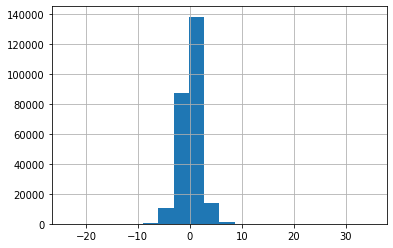

In [14]:
(train_df['x'].astype(float) - train_df['ix'].astype(float)).hist(bins=20)

<AxesSubplot:>

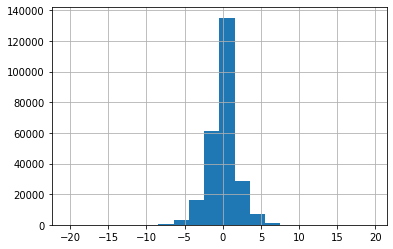

In [15]:
(train_df['y'].astype(float) - train_df['iy'].astype(float)).hist(bins=20)

<AxesSubplot:>

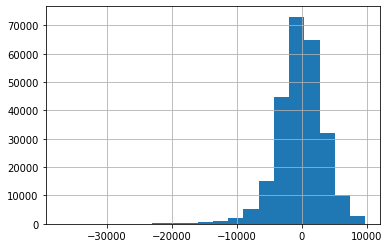

In [16]:
train_df['timediff'].astype(float).hist(bins=20)  # waypointとwifiのtimediff

<AxesSubplot:>

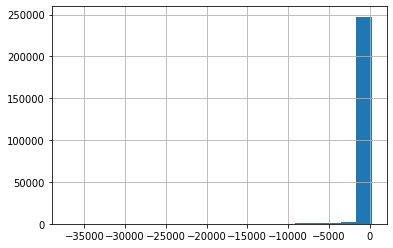

In [17]:
train_df['itimediff'].astype(float).hist(bins=20)  # waypointとwifiのtimediff

In [18]:
to_pickle(output_dir/train_save_file_name, train_df)

## test

In [19]:
ssubm_df

,site_id,path_id,timestamp,site_path_timestamp,real_timestamp,time_diff
0,5a0546857ecc773753327266,046cfa46be49fc10834815c6,0000000000009,5a0546857ecc773753327266_046cfa46be49fc1083481...,1578474564146,1578474564137
1,5a0546857ecc773753327266,046cfa46be49fc10834815c6,0000000009017,5a0546857ecc773753327266_046cfa46be49fc1083481...,1578474573154,1578474564137
2,5a0546857ecc773753327266,046cfa46be49fc10834815c6,0000000015326,5a0546857ecc773753327266_046cfa46be49fc1083481...,1578474579463,1578474564137
3,5a0546857ecc773753327266,046cfa46be49fc10834815c6,0000000018763,5a0546857ecc773753327266_046cfa46be49fc1083481...,1578474582900,1578474564137
4,5a0546857ecc773753327266,046cfa46be49fc10834815c6,0000000022328,5a0546857ecc773753327266_046cfa46be49fc1083481...,1578474586465,1578474564137
...,...,...,...,...,...,...
10128,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,0000000082589,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,1573731143307,1573731060718
10129,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,0000000085758,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,1573731146476,1573731060718
10130,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,0000000090895,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,1573731151613,1573731060718
10131,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,0000000096899,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,1573731157617,1573731060718


In [20]:
rows = []
test_wifi_count = []
test_time_diffs = []
for path_id, path_df in tqdm(ssubm_df.groupby('path_id')):
    
    site_id = path_df.iloc[0]['site_id']
    bssids = test_bssid[site_id]
    
    # wifiのdataをtxtから取得
    wifi_base_df = create_wifi_df(path_id)
    wifi_base_df = wifi_base_df[wifi_base_df['bssid'].isin(bssids)]
    
    wifi_timestamps = wifi_base_df['timestamp'].unique()  # not real
    path_time_diff = path_df['time_diff'].values[0]  # これをnot realにたすとrealのtimestampになる
    waypoint_timestamps = path_df['timestamp'].values  # not real
      
    for wifi_timestamp in wifi_timestamps:

        # 該当するtimestampのデータ群のみ取得
        wifi_time_uni = wifi_base_df[wifi_base_df['timestamp'] == wifi_timestamp]

        # wifiに最も近いwaypointを取得
        diffs = np.long(wifi_timestamp) - waypoint_timestamps.astype(np.long)  # waypointとwifiのdiff
        min_idx = np.abs(diffs).argmin()
        way_time = waypoint_timestamps[min_idx]  # not real

        # last seenとwaypointのtimediffを取得
        last_timediff = wifi_time_uni['last_seen_timestamp'].astype(int) - (np.long(way_time)+path_time_diff)
        wifi_time_uni['diff_abs'] = last_timediff.abs()
        wifi_time_uni = wifi_time_uni[wifi_time_uni['diff_abs'] <= LAST_TIME_DIFF_THRESHOLD]  # reset_indexしなくていい？
        test_time_diffs.extend(wifi_time_uni['diff_abs'].values)   

        test_wifi_count.append(len(wifi_time_uni))
        if len(wifi_time_uni) < WIFI_MIN_NUM:
            continue

        if len(wifi_time_uni) < WIFI_NUM:
            dummy_count = WIFI_NUM - len(wifi_time_uni)
            dummy_df = pd.DataFrame(np.tile(DUMMY_RECORD, (dummy_count, 1)), 
                                    columns=['timestamp', 'data_type', 'ssid', 'bssid', 'rssi', 'frequency', 'last_seen_timestamp'])
            wifi_time_uni = pd.concat([wifi_time_uni, dummy_df])

        timediff = int(way_time) - int(wifi_timestamp)  # waypointとwifiのtimediff
        wifi_time_uni = wifi_time_uni.head(WIFI_NUM)
        row = np.concatenate([wifi_time_uni['ssid'].to_numpy(),
                              wifi_time_uni['bssid'].to_numpy(), 
                              wifi_time_uni['rssi'].to_numpy(), 
                              wifi_time_uni['frequency'].to_numpy(), 
                              wifi_time_uni['diff_abs'].to_numpy(),
                              [way_time,
                               int(way_time) + int(path_time_diff),
                               path_id,
                               site_id,
                               timediff]])
        rows.append(row)
        
columns = [f'ssid_{i}' for i in range(WIFI_NUM)] + \
          [f'bssid_{i}' for i in range(WIFI_NUM)] + \
          [f'rssi_{i}' for i in range(WIFI_NUM)] + \
          [f'frequency_{i}' for i in range(WIFI_NUM)] + \
          [f'timediff_{i}' for i in range(WIFI_NUM)] + \
          ['timestamp', 'real_timestamp', 'path', 'site_id', 'timediff']
test_df = pd.DataFrame(rows, columns=columns)

100%|██████████| 626/626 [02:10<00:00,  4.80it/s]


In [21]:
test_df

,ssid_0,ssid_1,ssid_2,ssid_3,ssid_4,ssid_5,ssid_6,ssid_7,ssid_8,ssid_9,...,timediff_95,timediff_96,timediff_97,timediff_98,timediff_99,timestamp,real_timestamp,path,site_id,timediff
0,3c1e7602176e050694e3a5cf8ba5f6f725e3ec51,5c072340f8e500f7e62819ab82bb8998ecd0ef4e,a4e38996343460efde1140975529e97c9f9aa60b,d0af9d9c2709796ee07a0432de0e26298a64e3e8,a4e38996343460efde1140975529e97c9f9aa60b,da39a3ee5e6b4b0d3255bfef95601890afd80709,208255716aecce985d8f7a2bb8117b4dee2d53c5,da39a3ee5e6b4b0d3255bfef95601890afd80709,07b466ea3782f19a25830149eb173cfc5c049246,da39a3ee5e6b4b0d3255bfef95601890afd80709,...,NaN,NaN,NaN,NaN,NaN,0000000000010,1573190310863,00ff0c9a71cc37a2ebdd0f05,5da1389e4db8ce0c98bd0547,-1170
1,d0af9d9c2709796ee07a0432de0e26298a64e3e8,5c072340f8e500f7e62819ab82bb8998ecd0ef4e,3c1e7602176e050694e3a5cf8ba5f6f725e3ec51,da39a3ee5e6b4b0d3255bfef95601890afd80709,a4e38996343460efde1140975529e97c9f9aa60b,a4e38996343460efde1140975529e97c9f9aa60b,07b466ea3782f19a25830149eb173cfc5c049246,208255716aecce985d8f7a2bb8117b4dee2d53c5,da39a3ee5e6b4b0d3255bfef95601890afd80709,fae4d5efee5c89ade8adbdf72d3e888074d22a29,...,NaN,NaN,NaN,NaN,NaN,0000000004048,1573190314901,00ff0c9a71cc37a2ebdd0f05,5da1389e4db8ce0c98bd0547,1000
2,5c072340f8e500f7e62819ab82bb8998ecd0ef4e,d0af9d9c2709796ee07a0432de0e26298a64e3e8,3c1e7602176e050694e3a5cf8ba5f6f725e3ec51,da39a3ee5e6b4b0d3255bfef95601890afd80709,a4e38996343460efde1140975529e97c9f9aa60b,208255716aecce985d8f7a2bb8117b4dee2d53c5,a4e38996343460efde1140975529e97c9f9aa60b,da39a3ee5e6b4b0d3255bfef95601890afd80709,07b466ea3782f19a25830149eb173cfc5c049246,25055861b712f167ba58320e846a4aa70f811204,...,NaN,NaN,NaN,NaN,NaN,0000000004048,1573190314901,00ff0c9a71cc37a2ebdd0f05,5da1389e4db8ce0c98bd0547,-876
3,d0af9d9c2709796ee07a0432de0e26298a64e3e8,208255716aecce985d8f7a2bb8117b4dee2d53c5,a4e38996343460efde1140975529e97c9f9aa60b,3c1e7602176e050694e3a5cf8ba5f6f725e3ec51,5c072340f8e500f7e62819ab82bb8998ecd0ef4e,da39a3ee5e6b4b0d3255bfef95601890afd80709,da39a3ee5e6b4b0d3255bfef95601890afd80709,07b466ea3782f19a25830149eb173cfc5c049246,a4e38996343460efde1140975529e97c9f9aa60b,25055861b712f167ba58320e846a4aa70f811204,...,NaN,NaN,NaN,NaN,NaN,0000000004048,1573190314901,00ff0c9a71cc37a2ebdd0f05,5da1389e4db8ce0c98bd0547,-2768
4,d0af9d9c2709796ee07a0432de0e26298a64e3e8,a4e38996343460efde1140975529e97c9f9aa60b,3c1e7602176e050694e3a5cf8ba5f6f725e3ec51,208255716aecce985d8f7a2bb8117b4dee2d53c5,5c072340f8e500f7e62819ab82bb8998ecd0ef4e,da39a3ee5e6b4b0d3255bfef95601890afd80709,a4e38996343460efde1140975529e97c9f9aa60b,f2921f9fa47c704da162c06fc348a98e83464d71,da39a3ee5e6b4b0d3255bfef95601890afd80709,07b466ea3782f19a25830149eb173cfc5c049246,...,NaN,NaN,NaN,NaN,NaN,0000000012526,1573190323379,00ff0c9a71cc37a2ebdd0f05,5da1389e4db8ce0c98bd0547,3833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37434,45671173620a277ceda4ed5411413875dc4cddd0,94c9c12f67502bf93f4ced30194b269d9cec6f92,45671173620a277ceda4ed5411413875dc4cddd0,6ad1c6bb0aeaa218fa705f0f8dc901c973396a9e,d78e0816ec0328992fc6025f61304812cf54febf,f0de7db5c2e4bf6c27f0f0b941a941cdc95ac6c5,2e40049edd5106db3965286eb2446f3c14b46180,b7e6027447eb1f81327d66cfd3adbe557aabf26c,7182afc4e5c212133d5d7d76eb3df6c24618302b,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,...,NaN,NaN,NaN,NaN,NaN,0000000060483,1578465376100,ffcd9524c80c0fa5bb859eaf,5a0546857ecc773753327266,574
37435,94c9c12f67502bf93f4ced30194b269d9cec6f92,45671173620a277ceda4ed5411413875dc4cddd0,45671173620a277ceda4ed5411413875dc4cddd0,6ad1c6bb0aeaa218fa705f0f8dc901c973396a9e,b7e6027447eb1f81327d66cfd3adbe557aabf26c,d78e0816ec0328992fc6025f61304812cf54febf,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,7182afc4e5c212133d5d7d76eb3df6c24618302b,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,...,NaN,NaN,NaN,NaN,NaN,0000000060483,1578465376100,ffcd9524c80c0fa5bb859eaf,5a0546857ecc773753327266,-1309
37436,94c9c12f67502bf93f4ced30194b269d9cec6f92,45671173620a277ceda4ed5411413875dc4cddd0

In [22]:
test_df['site_path_timestamp'] = test_df['site_id'] + '_' + test_df['path'] +'_' + test_df['timestamp']
test_df

,ssid_0,ssid_1,ssid_2,ssid_3,ssid_4,ssid_5,ssid_6,ssid_7,ssid_8,ssid_9,...,timediff_96,timediff_97,timediff_98,timediff_99,timestamp,real_timestamp,path,site_id,timediff,site_path_timestamp
0,3c1e7602176e050694e3a5cf8ba5f6f725e3ec51,5c072340f8e500f7e62819ab82bb8998ecd0ef4e,a4e38996343460efde1140975529e97c9f9aa60b,d0af9d9c2709796ee07a0432de0e26298a64e3e8,a4e38996343460efde1140975529e97c9f9aa60b,da39a3ee5e6b4b0d3255bfef95601890afd80709,208255716aecce985d8f7a2bb8117b4dee2d53c5,da39a3ee5e6b4b0d3255bfef95601890afd80709,07b466ea3782f19a25830149eb173cfc5c049246,da39a3ee5e6b4b0d3255bfef95601890afd80709,...,NaN,NaN,NaN,NaN,0000000000010,1573190310863,00ff0c9a71cc37a2ebdd0f05,5da1389e4db8ce0c98bd0547,-1170,5da1389e4db8ce0c98bd0547_00ff0c9a71cc37a2ebdd0...
1,d0af9d9c2709796ee07a0432de0e26298a64e3e8,5c072340f8e500f7e62819ab82bb8998ecd0ef4e,3c1e7602176e050694e3a5cf8ba5f6f725e3ec51,da39a3ee5e6b4b0d3255bfef95601890afd80709,a4e38996343460efde1140975529e97c9f9aa60b,a4e38996343460efde1140975529e97c9f9aa60b,07b466ea3782f19a25830149eb173cfc5c049246,208255716aecce985d8f7a2bb8117b4dee2d53c5,da39a3ee5e6b4b0d3255bfef95601890afd80709,fae4d5efee5c89ade8adbdf72d3e888074d22a29,...,NaN,NaN,NaN,NaN,0000000004048,1573190314901,00ff0c9a71cc37a2ebdd0f05,5da1389e4db8ce0c98bd0547,1000,5da1389e4db8ce0c98bd0547_00ff0c9a71cc37a2ebdd0...
2,5c072340f8e500f7e62819ab82bb8998ecd0ef4e,d0af9d9c2709796ee07a0432de0e26298a64e3e8,3c1e7602176e050694e3a5cf8ba5f6f725e3ec51,da39a3ee5e6b4b0d3255bfef95601890afd80709,a4e38996343460efde1140975529e97c9f9aa60b,208255716aecce985d8f7a2bb8117b4dee2d53c5,a4e38996343460efde1140975529e97c9f9aa60b,da39a3ee5e6b4b0d3255bfef95601890afd80709,07b466ea3782f19a25830149eb173cfc5c049246,25055861b712f167ba58320e846a4aa70f811204,...,NaN,NaN,NaN,NaN,0000000004048,1573190314901,00ff0c9a71cc37a2ebdd0f05,5da1389e4db8ce0c98bd0547,-876,5da1389e4db8ce0c98bd0547_00ff0c9a71cc37a2ebdd0...
3,d0af9d9c2709796ee07a0432de0e26298a64e3e8,208255716aecce985d8f7a2bb8117b4dee2d53c5,a4e38996343460efde1140975529e97c9f9aa60b,3c1e7602176e050694e3a5cf8ba5f6f725e3ec51,5c072340f8e500f7e62819ab82bb8998ecd0ef4e,da39a3ee5e6b4b0d3255bfef95601890afd80709,da39a3ee5e6b4b0d3255bfef95601890afd80709,07b466ea3782f19a25830149eb173cfc5c049246,a4e38996343460efde1140975529e97c9f9aa60b,25055861b712f167ba58320e846a4aa70f811204,...,NaN,NaN,NaN,NaN,0000000004048,1573190314901,00ff0c9a71cc37a2ebdd0f05,5da1389e4db8ce0c98bd0547,-2768,5da1389e4db8ce0c98bd0547_00ff0c9a71cc37a2ebdd0...
4,d0af9d9c2709796ee07a0432de0e26298a64e3e8,a4e38996343460efde1140975529e97c9f9aa60b,3c1e7602176e050694e3a5cf8ba5f6f725e3ec51,208255716aecce985d8f7a2bb8117b4dee2d53c5,5c072340f8e500f7e62819ab82bb8998ecd0ef4e,da39a3ee5e6b4b0d3255bfef95601890afd80709,a4e38996343460efde1140975529e97c9f9aa60b,f2921f9fa47c704da162c06fc348a98e83464d71,da39a3ee5e6b4b0d3255bfef95601890afd80709,07b466ea3782f19a25830149eb173cfc5c049246,...,NaN,NaN,NaN,NaN,0000000012526,1573190323379,00ff0c9a71cc37a2ebdd0f05,5da1389e4db8ce0c98bd0547,3833,5da1389e4db8ce0c98bd0547_00ff0c9a71cc37a2ebdd0...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37434,45671173620a277ceda4ed5411413875dc4cddd0,94c9c12f67502bf93f4ced30194b269d9cec6f92,45671173620a277ceda4ed5411413875dc4cddd0,6ad1c6bb0aeaa218fa705f0f8dc901c973396a9e,d78e0816ec0328992fc6025f61304812cf54febf,f0de7db5c2e4bf6c27f0f0b941a941cdc95ac6c5,2e40049edd5106db3965286eb2446f3c14b46180,b7e6027447eb1f81327d66cfd3adbe557aabf26c,7182afc4e5c212133d5d7d76eb3df6c24618302b,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,...,NaN,NaN,NaN,NaN,0000000060483,1578465376100,ffcd9524c80c0fa5bb859eaf,5a0546857ecc773753327266,574,5a0546857ecc773753327266_ffcd9524c80c0fa5bb859...
37435,94c9c12f67502bf93f4ced30194b269d9cec6f92,45671173620a277ceda4ed5411413875dc4cddd0,45671173620a277ceda4ed5411413875dc4cddd0,6ad1c6bb0aeaa218fa705f0f8dc901c973396a9e,b7e6027447eb1f81327d66cfd3adbe557aabf26c,d78e0816ec0328992fc6025f61304812cf54febf,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,7182afc4e5c212133d5d7d76eb3df6c246

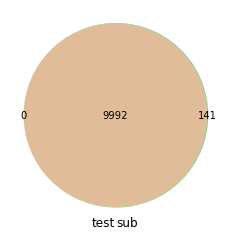

In [23]:
from matplotlib_venn import venn2
venn2(subsets=(set(test_df['site_path_timestamp'].unique()), set(ssubm_df['site_path_timestamp'])), set_labels=('test', 'sub'))

In [24]:
test_df = test_df.sort_values('site_path_timestamp').reset_index(drop=True)

In [45]:
test_df['timestamp'].astype(int).sort_values()

994           1
993           1
1585          6
28446         6
3867          6
          ...  
17934    724803
17935    724803
12063    725600
12062    725600
12061    725600
Name: timestamp, Length: 37439, dtype: int64

In [33]:
test_df['site_path_timestamp'].nunique()

9992

In [32]:
test_df['timestamp'].nunique()

9229

In [25]:
to_pickle(output_dir/test_save_file_name, test_df)

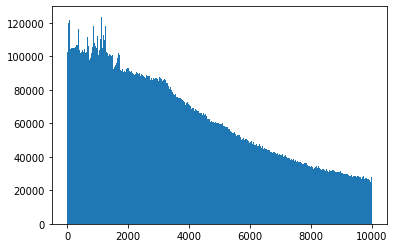

,count,mean,std,min,25%,50%,75%,max
0,31885972.0,3772.337584,2676.269167,0.0,1493.0,3267.0,5685.0,10000.0


In [26]:
plt.hist(np.abs(train_time_diffs), bins=500)
plt.show()
pd.DataFrame(np.abs(train_time_diffs)).describe().T

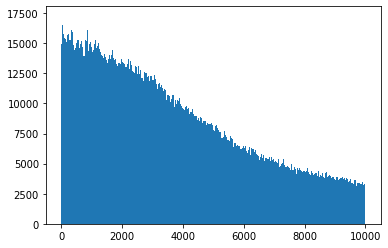

,count,mean,std,min,25%,50%,75%,max
0,4356390.0,3659.454979,2638.856246,0.0,1451.0,3125.0,5470.0,10000.0


In [27]:
plt.hist(np.abs(test_time_diffs), bins=500)
plt.show()
pd.DataFrame(np.abs(test_time_diffs)).describe().T

In [28]:
test_wifi_count_np = np.array(test_wifi_count)
print('WiFi10件以下の件数:{}'.format(len(test_wifi_count_np[test_wifi_count_np < 10])))
print('WiFi20件以下の件数:{}'.format(len(test_wifi_count_np[test_wifi_count_np < 20])))

WiFi10件以下の件数:287
WiFi20件以下の件数:841


In [29]:
test_wifi_count_np[test_wifi_count_np < 10]

array([0, 9, 0, 0, 0, 0, 0, 0, 8, 0, 9, 0, 6, 9, 3, 0, 0, 7, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 7, 7,
       9, 3, 8, 9, 0, 0, 0, 0, 0, 0, 5, 8, 0, 7, 7, 8, 9, 9, 4, 6, 9, 0,
       2, 0, 6, 6, 8, 0, 0, 0, 0, 0, 6, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 2, 0, 0, 3, 0, 0, 0, 1, 0, 7, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 7, 8, 9, 9, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 8, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 4, 9, 9, 0, 0, 0, 0, 5, 8,
       7, 0, 0, 0, 0, 0, 0, 2, 9, 2, 0, 0, 0, 0, 9, 8, 0, 7, 0, 0, 0, 9,
       0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 6,
       9, 2, 0, 0, 8, 8, 8, 8, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 6, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 2, 6, 0, 0, 0, 0, 0, 0, 0, 0,
       6, 0, 0, 0, 0, 6, 0, 8, 0, 0, 0, 7, 0, 8, 0, 0, 0, 0, 7, 9, 1, 0,
       0])

In [30]:
pd.Series(test_wifi_count).value_counts().sort_index()

0      205
1        5
2        8
3        3
4        3
      ... 
527      1
529      1
533      1
542      1
552      1
Length: 497, dtype: int64

In [8]:
root_dir = Path('../input/')
with open(root_dir/'2kaido_wifi_dataset_v3/train_10000_7.pkl', 'rb') as f:
  train_df = pickle.load(f)

(array([358627., 315536., 318632., 351619., 310482., 314118., 336513.,
        307773., 331066., 316490., 316864., 347042., 328331., 318973.,
        304309., 286342., 298027., 285497., 278488., 282804., 283229.,
        276648., 276303., 276340., 273304., 271646., 272046., 267504.,
        265580., 265113., 268264., 261892., 256563., 246795., 238686.,
        233708., 230614., 228471., 222407., 221386., 214857., 211922.,
        209717., 206689., 203349., 199946., 194133., 191596., 187992.,
        186569., 182637., 181141., 175855., 171355., 167625., 165236.,
        161395., 156675., 156043., 152917., 150382., 147025., 146191.,
        144232., 139484., 138971., 134748., 133893., 131069., 128506.,
        127295., 124293., 123200., 119295., 116115., 115905., 114491.,
        111710., 111716., 107204., 106302., 103547., 105196., 102409.,
        100761.,  98478.,  97618.,  97805.,  94154.,  96018.,  92727.,
         91877.,  90044.,  88599.,  89317.,  89714.,  87139.,  86236.,
      

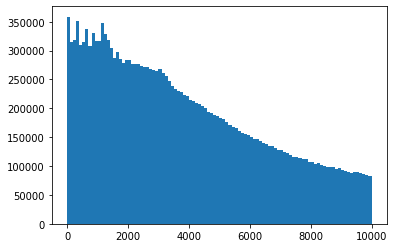

In [30]:
timediff = train_df.filter(like='timediff_').values.astype(float)
plt.hist(timediff[~np.isnan(timediff)], bins=100)